In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import cycle
import warnings
warnings.filterwarnings("ignore")



class Classifier:
    def __init__(self, params_lr=None, params_svm=None, params_lda=None, params_qda=None, params_rfc=None):
        self.model_lr = LogisticRegression(**(params_lr if params_lr is not None else {}), n_jobs=-1)
        self.model_svm = SVC(**(params_svm if params_svm is not None else {}))
        self.model_lda = LinearDiscriminantAnalysis(**(params_lda if params_lda is not None else {}))
        self.model_qda = QuadraticDiscriminantAnalysis(**(params_qda if params_qda is not None else {}))
        self.model_rfc = RandomForestClassifier(**(params_rfc if params_rfc is not None else {}))
        self.model_tree = tree.DecisionTreeClassifier()
        
    def fit(self, X_train, y_train, X_val,model_name):
        if model_name == 'lr':
            self.model_lr.fit(X_train, y_train)
            y_pred = self.model_lr.predict(X_val)
            y_prob = self.model_lr.predict_proba(X_val)
        elif model_name == 'svm':
            self.model_svm.fit(X_train, y_train)
            y_pred = self.model_svm.predict(X_val)
            y_prob = self.model_svm.predict_proba(X_val)
        elif model_name == 'lda':
            self.model_lda.fit(X_train, y_train)
            y_pred = self.model_lda.predict(X_val)
            y_prob = self.model_lda.predict_proba(X_val)
        elif model_name == 'qda':
            self.model_qda.fit(X_train, y_train)
            y_pred = self.model_qda.predict(X_train)
            y_prob = self.model_qda.predict_proba(X_val)
        elif model_name == 'tree':
            self.model_tree.fit(X_train, y_train)
            y_pred = self.model_tree.predict(X_val)
            y_prob = self.model_tree.predict_proba(X_val)
        elif model_name == 'rfc':
            self.model_rfc.fit(X_train, y_train)
            y_pred = self.model_rfc.predict(X_val)
            y_prob = self.model_rfc.predict_proba(X_val)
        else:
            raise ValueError("Invalid model name. Please choose from 'lr', 'svm', 'lda', or 'qda', 'tree', 'rfc'.")

        return y_pred, y_prob

    def tune(self, X_train, y_train, X_val, param_grid, model_name):
        if model_name == 'lr':
            grid = GridSearchCV(self.model_lr, param_grid, n_jobs=-1)
        elif model_name == 'svm':
            grid = GridSearchCV(self.model_svm, param_grid, n_jobs=-1)
        elif model_name == 'lda':
            grid = GridSearchCV(self.model_lda, param_grid, n_jobs=-1)
        elif model_name == 'qda':
            grid = GridSearchCV(self.model_qda, param_grid, n_jobs=-1)
        elif model_name == 'tree':  
            grid = GridSearchCV(self.model_tree, param_grid, n_jobs=-1)
        elif model_name == 'rfc':
            grid = GridSearchCV(self.model_rfc, param_grid, n_jobs=-1)
        else:
            raise ValueError("Invalid model name. Please choose from 'lr', 'svm', 'lda', or 'qda'.")

        grid.fit(X_train, y_train)
        best_params = grid.best_params_
        y_pred_opt = grid.predict(X_val)
        return best_params, y_pred_opt

    
    
    def report(self, y_pred_opt, y_val, y_prob):
        auc_score = roc_auc_score(y_val, y_prob, multi_class='ovr', average='weighted')
        accuracy = accuracy_score(y_val, y_pred_opt)
        report = classification_report(y_val, y_pred_opt)
        confusion = confusion_matrix(y_val, y_pred_opt)
        percision = precision_score(y_val, y_pred_opt, average='weighted')
        recall = recall_score(y_val, y_pred_opt, average='weighted')
        f1 = f1_score(y_val, y_pred_opt, average='weighted')
        support = np.unique(y_val, return_counts=True)[1]
        return auc_score, accuracy, report, confusion, percision, recall, f1, support


    def plot(self, confusion, y_prob, y_val):
        # Initialize the figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

        # Confusion Matrix
        sns.heatmap(confusion, annot=True, fmt='d', cmap='YlGnBu', ax=ax1)
        ax1.set_title('Confusion Matrix')
        ax1.set_xlabel('Predicted Label')
        ax1.set_ylabel('True Label')

        # ROC Curve
        n_classes = y_prob.shape[1]
        y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        colors = cycle(['blue', 'red', 'green', 'yellow', 'cyan', 'magenta', 'black'])
        for i, color in zip(range(n_classes), colors):
            ax2.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

        ax2.plot([0, 1], [0, 1], 'k--', lw=2)
        ax2.set_xlim([0.0, 1.0])
        ## After see all roc curve, set the ylim start from 0.6
        ax2.set_ylim([0.0, 1.0])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve')
        ax2.legend(loc='lower right')

        plt.tight_layout()
        plt.show()


## Data Processing，we decided to use features from Chi-square test as the input for the model
df1 = pd.read_csv('data/cleaned.csv')

X = df1[['host_response_time', 'host_response_rate', 'host_is_superhost',
       'room_type', 'accommodates', 'minimum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'host_years', 'review_years_range']]
y = df1['popularity']

## Normalize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Define the parameters for the models
params_lr={'max_iter': 1000, 'C': 0.5}
params_svm={'kernel': 'linear', 'C': 0.5, 'probability': True}
params_lda = {'solver': 'svd'}
params_qda = {'reg_param': 0.5}
params_rfc = {'n_estimators': 100, 'max_depth': 10,'bootstrap': True}

## Define the parameter grid for the models
params_lr_grid = {'max_iter': [1000, 2000, 3000], 'C': [0.1, 0.5, 1.0],
                  'penalty': ['l1', 'l2','none'],
                  'solver': ['liblinear', 'saga']}

params_svm_grid = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                   'C': [0.1, 0.5, 1.0],
                   'gamma': ['scale', 'auto']}

params_lda_grid = {'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]}
params_qda_grid = {'reg_param': [0.1, 1, 10]}
params_rfc_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10], 
                   'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}

AUC Score: 0.9138102129339307
Accuracy: 0.8704433497536945
Report:               precision    recall  f1-score   support

           0       0.85      0.86      0.85       507
           1       0.88      0.90      0.89       549
           2       0.79      0.76      0.77       466
           3       0.96      0.95      0.95       508

    accuracy                           0.87      2030
   macro avg       0.87      0.87      0.87      2030
weighted avg       0.87      0.87      0.87      2030

Confusion Matrix: [[437   8  44  18]
 [  4 495  50   0]
 [ 48  62 354   2]
 [ 27   0   0 481]]
Percision: 0.8701004832658373
Recall: 0.8704433497536945
F1: 0.8701253354012178
Support: [507 549 466 508]


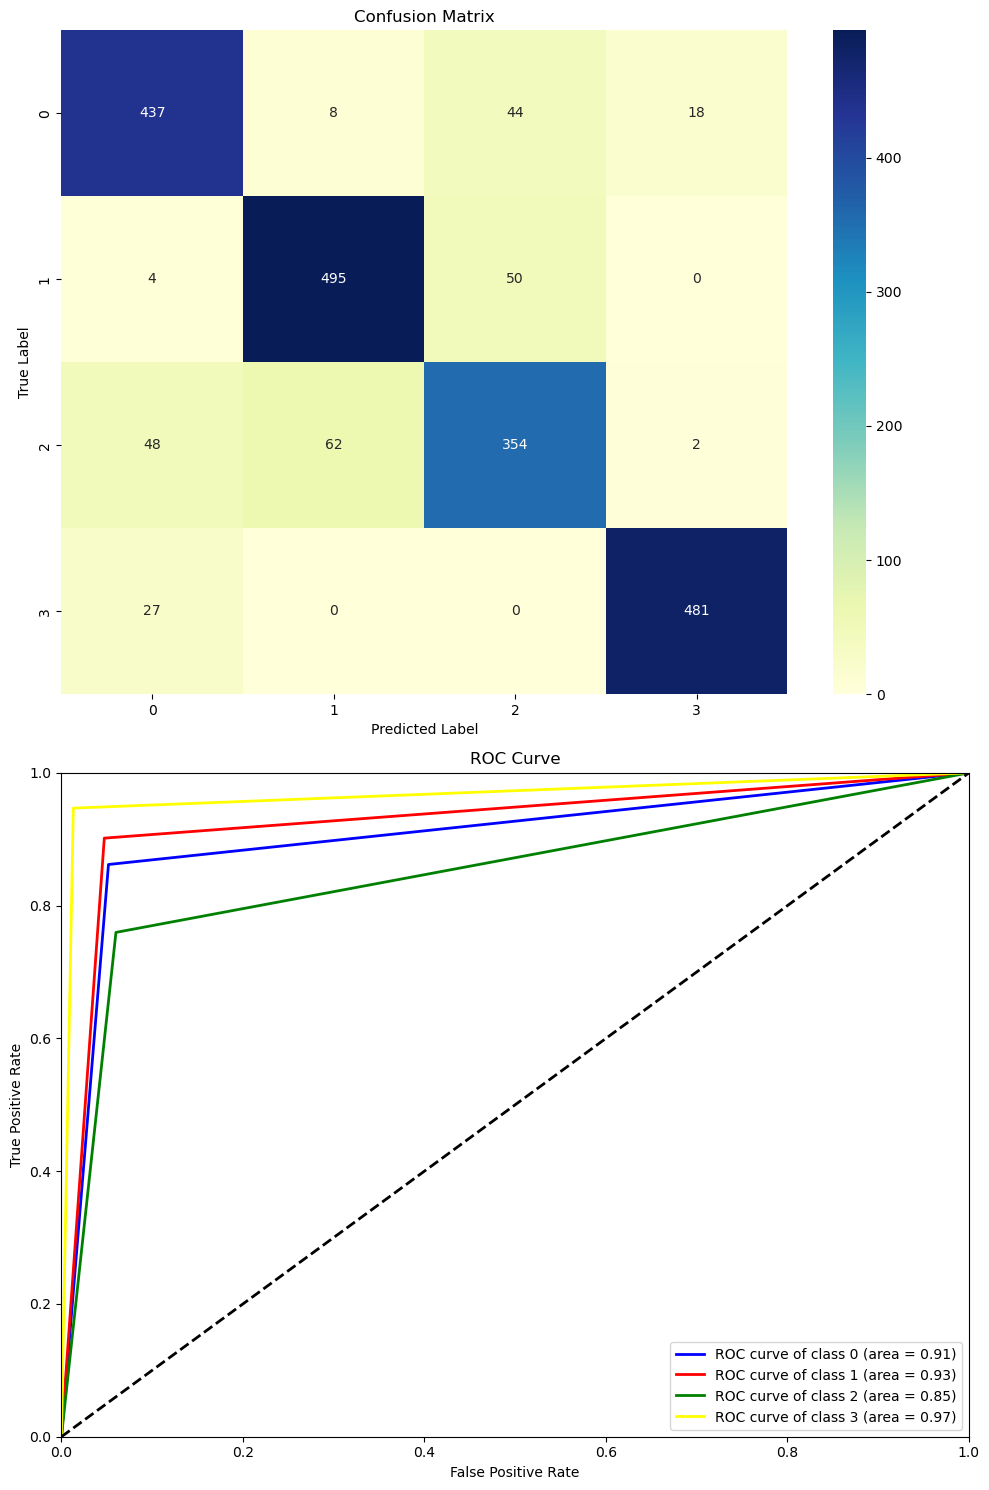

In [59]:
model_tree = Classifier()
y_pred_rfc, y_prob_rfc  = model_tree.fit(X_train, y_train, X_test, 'tree')

auc_score, tree_accuracy, report, confusion, percision, recall, f1, support = model_tree.report(y_pred_rfc, y_test, y_prob_rfc)

print(f"AUC Score: {auc_score}")
print(f"Accuracy: {tree_accuracy}")
print(f"Report: {report}")
print(f"Confusion Matrix: {confusion}")
print(f"Percision: {percision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Support: {support}")

model_tree.plot(confusion, y_prob_rfc, y_test)

Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
AUC Score: 0.9802690973739856
Accuracy: 0.905911330049261
Report:               precision    recall  f1-score   support

           0       0.88      0.89      0.88       507
           1       0.93      0.94      0.94       549
           2       0.84      0.87      0.85       466
           3       0.98      0.92      0.95       508

    accuracy                           0.91      2030
   macro avg       0.91      0.90      0.90      2030
weighted avg       0.91      0.91      0.91      2030

Precision: 0.9076042089347286
Recall: 0.905911330049261
F1 Score: 0.9064792336477188
Support: [507 549 466 508]


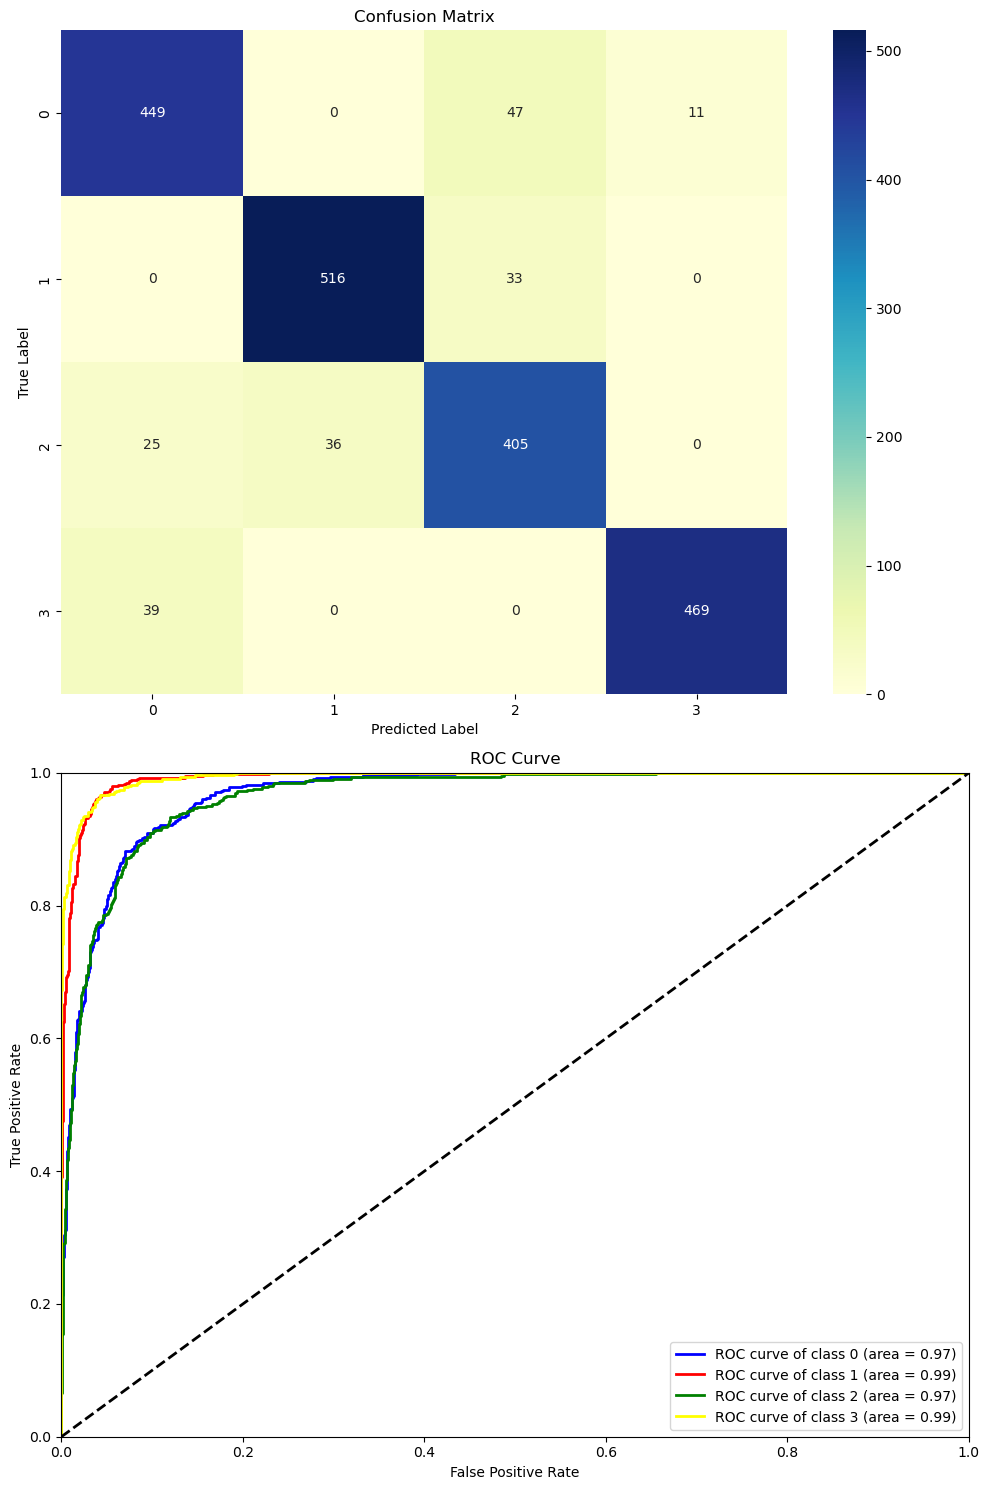

In [55]:
model_rfc = Classifier(params_rfc=params_rfc)

y_pred_rfc, y_prob_rfc = model_rfc.fit(X_train, y_train, X_test, 'rfc')


best_parameters, y_pred_opt = model_rfc.tune(X_train, y_train, X_test, params_rfc_grid, 'rfc')
print(f"Best parameters: {best_parameters}")

auc_score, rfc_accuracy, report, confusion, percision, recall, f1, support = model_rfc.report(y_pred_opt, y_test, y_prob_rfc)

print(f"AUC Score: {auc_score}")
print(f"Accuracy: {rfc_accuracy}")
print(f"Report: {report}")
print(f"Precision: {percision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Support: {support}")

model_rfc.plot(confusion, y_prob_rfc, y_test)

Best Parameters: {'reg_param': 0.1}

Quadratic Discriminant Analysis
AUC: 0.8130403268209903
Accuracy: 0.5596059113300492
Report:               precision    recall  f1-score   support

           0       0.47      0.64      0.54       507
           1       0.75      0.43      0.54       549
           2       0.37      0.36      0.37       466
           3       0.70      0.81      0.75       508

    accuracy                           0.56      2030
   macro avg       0.57      0.56      0.55      2030
weighted avg       0.58      0.56      0.56      2030

Confusion Matrix: [[322  14  39 132]
 [ 70 235 238   6]
 [197  65 168  36]
 [ 91   1   5 411]]
Percision: 0.581540264912331
Recall: 0.5596059113300492
F1: 0.5550226605826067
Support: [507 549 466 508]


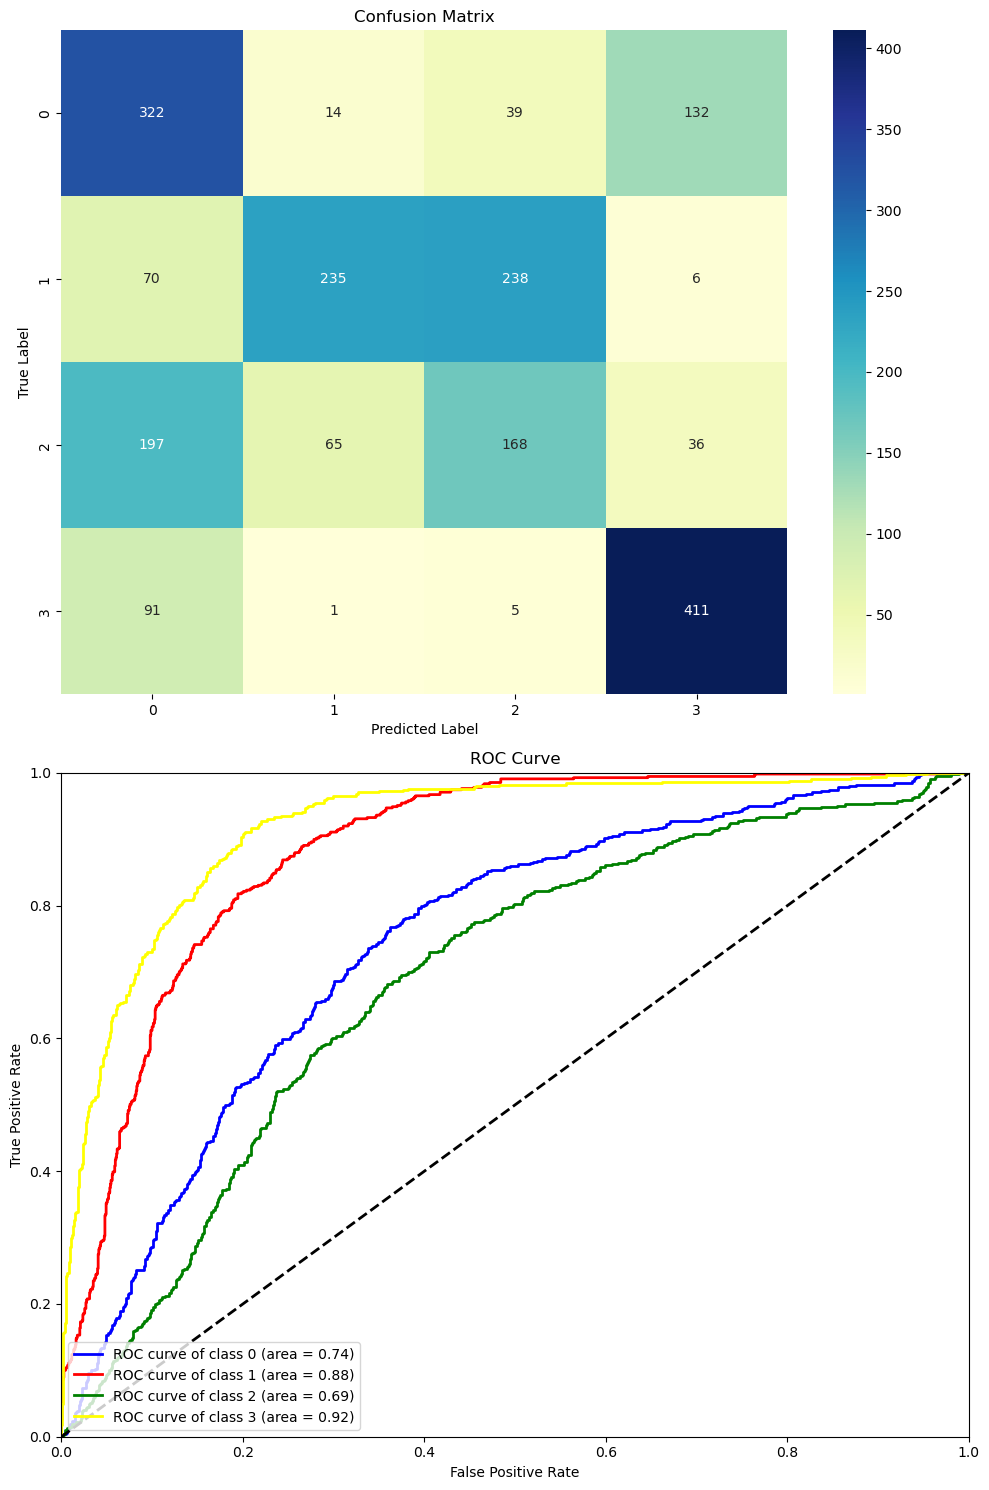

In [4]:
model_qda = Classifier(params_qda=params_qda)

## Fit the model
y_pred_qda, y_prob = model_qda.fit(X_train, y_train, X_test,'qda')

## Fine tune the model and get the best parameters
best_parameters, y_pred_opt = model_qda.tune(X_train, y_train, X_test, params_qda_grid, 'qda')
print(f"Best Parameters: {best_parameters}")

## Get the report for each metric
auc_score, qda_accuracy, report, confusion, percision, recall, f1, support = model_qda.report(y_pred_opt, y_test, y_prob)

print("\nQuadratic Discriminant Analysis")
print(f"AUC: {auc_score}")
print(f"Accuracy: {qda_accuracy}")
print(f"Report: {report}")
print(f"Confusion Matrix: {confusion}")
print(f"Percision: {percision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Support: {support}")

## Plot the confusion matrix and ROC curve
model_qda.plot(confusion, y_prob, y_test)

Best Parameters: {'shrinkage': 'auto', 'solver': 'lsqr'}

Linear Discriminant Analysis
AUC: 0.8472989293418315
Accuracy: 0.6113300492610837
Report:               precision    recall  f1-score   support

           0       0.52      0.47      0.49       507
           1       0.64      0.84      0.73       549
           2       0.45      0.35      0.39       466
           3       0.78      0.75      0.76       508

    accuracy                           0.61      2030
   macro avg       0.60      0.60      0.59      2030
weighted avg       0.60      0.61      0.60      2030

Confusion Matrix: [[239  59 126  83]
 [ 15 460  71   3]
 [ 87 197 162  20]
 [121   2   5 380]]
Percision: 0.6002972860906243
Recall: 0.6113300492610837
F1: 0.6005223794231015
Support: [507 549 466 508]


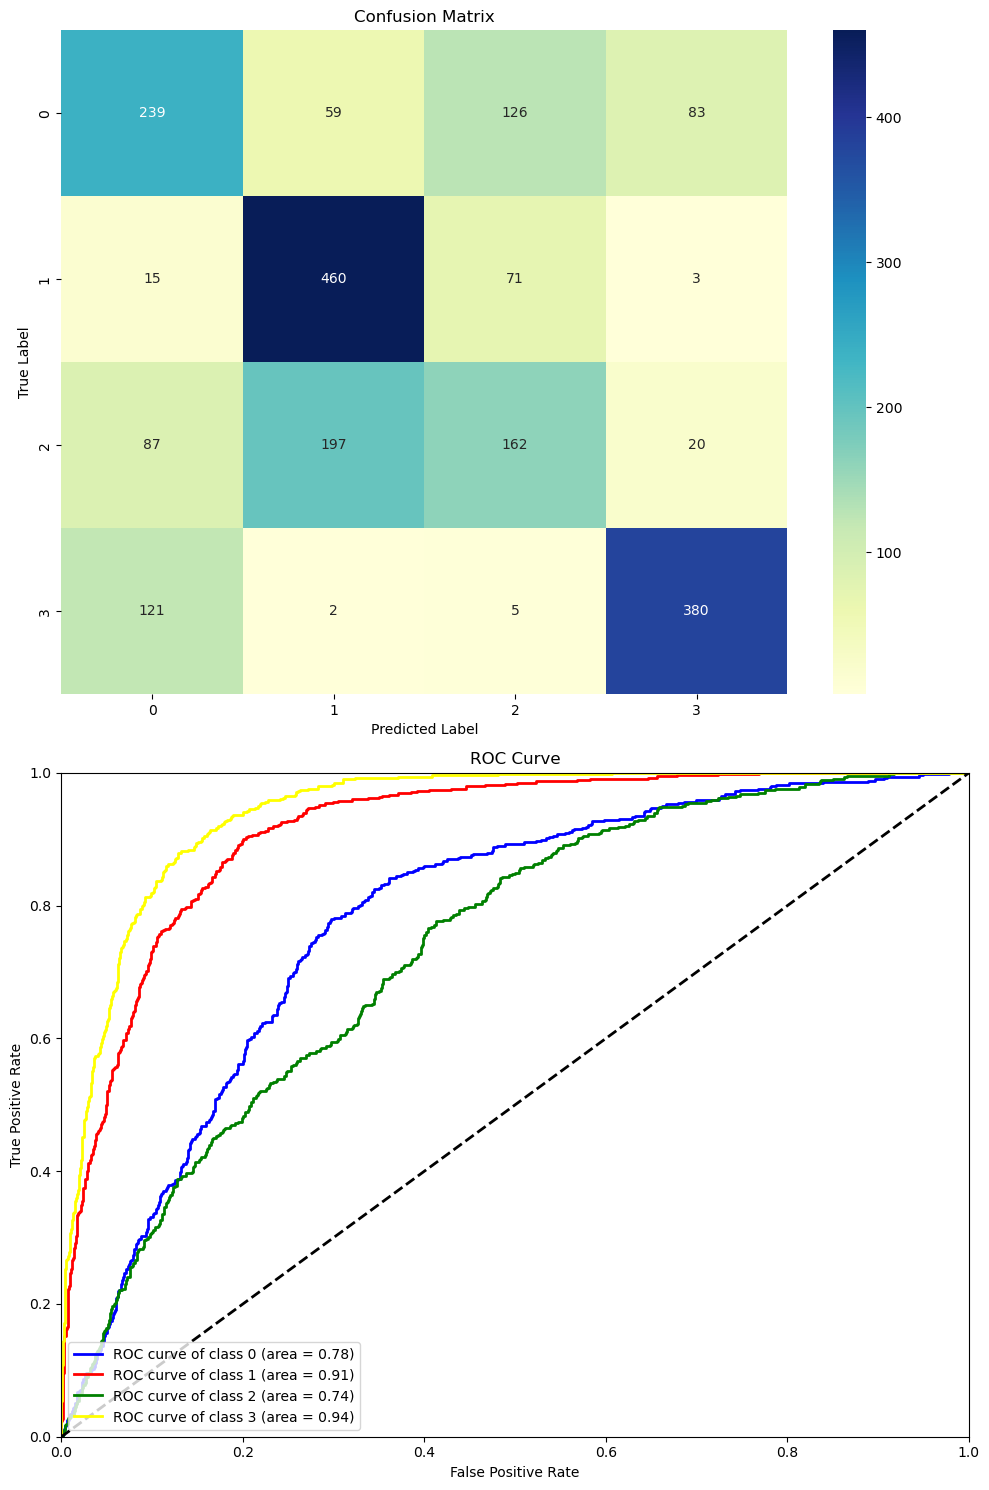

In [5]:
model_lda = Classifier(params_lda=params_lda)

## Fit the model
y_pred_lda, y_prob = model_lda.fit(X_train, y_train, X_test,'lda')

## Fine tune the model and get the best parameters
best_parameters, y_pred_opt = model_lda.tune(X_train, y_train, X_test, params_lda_grid, 'lda')
print(f"Best Parameters: {best_parameters}")

## Get the report for each metric
auc_score, lda_accuracy, report, confusion, percision, recall, f1, support = model_lda.report(y_pred_opt, y_test, y_prob)

print("\nLinear Discriminant Analysis")
print(f"AUC: {auc_score}")
print(f"Accuracy: {lda_accuracy}")
print(f"Report: {report}")
print(f"Confusion Matrix: {confusion}")
print(f"Percision: {percision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Support: {support}")

## Plot the confusion matrix and ROC curve
model_lda.plot(confusion, y_prob, y_test)

Best Parameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}

 Support Vector Machine
AUC: 0.878044471043591
Accuracy: 0.7605911330049261
Report:               precision    recall  f1-score   support

           0       0.68      0.76      0.71       507
           1       0.79      0.86      0.82       549
           2       0.63      0.53      0.57       466
           3       0.94      0.87      0.90       508

    accuracy                           0.76      2030
   macro avg       0.76      0.75      0.75      2030
weighted avg       0.76      0.76      0.76      2030

Confusion Matrix: [[383  18  77  29]
 [ 12 472  65   0]
 [111 109 246   0]
 [ 59   2   4 443]]
Percision: 0.7606263520269367
Recall: 0.7605911330049261
F1: 0.7583377482677404
Support: [507 549 466 508]


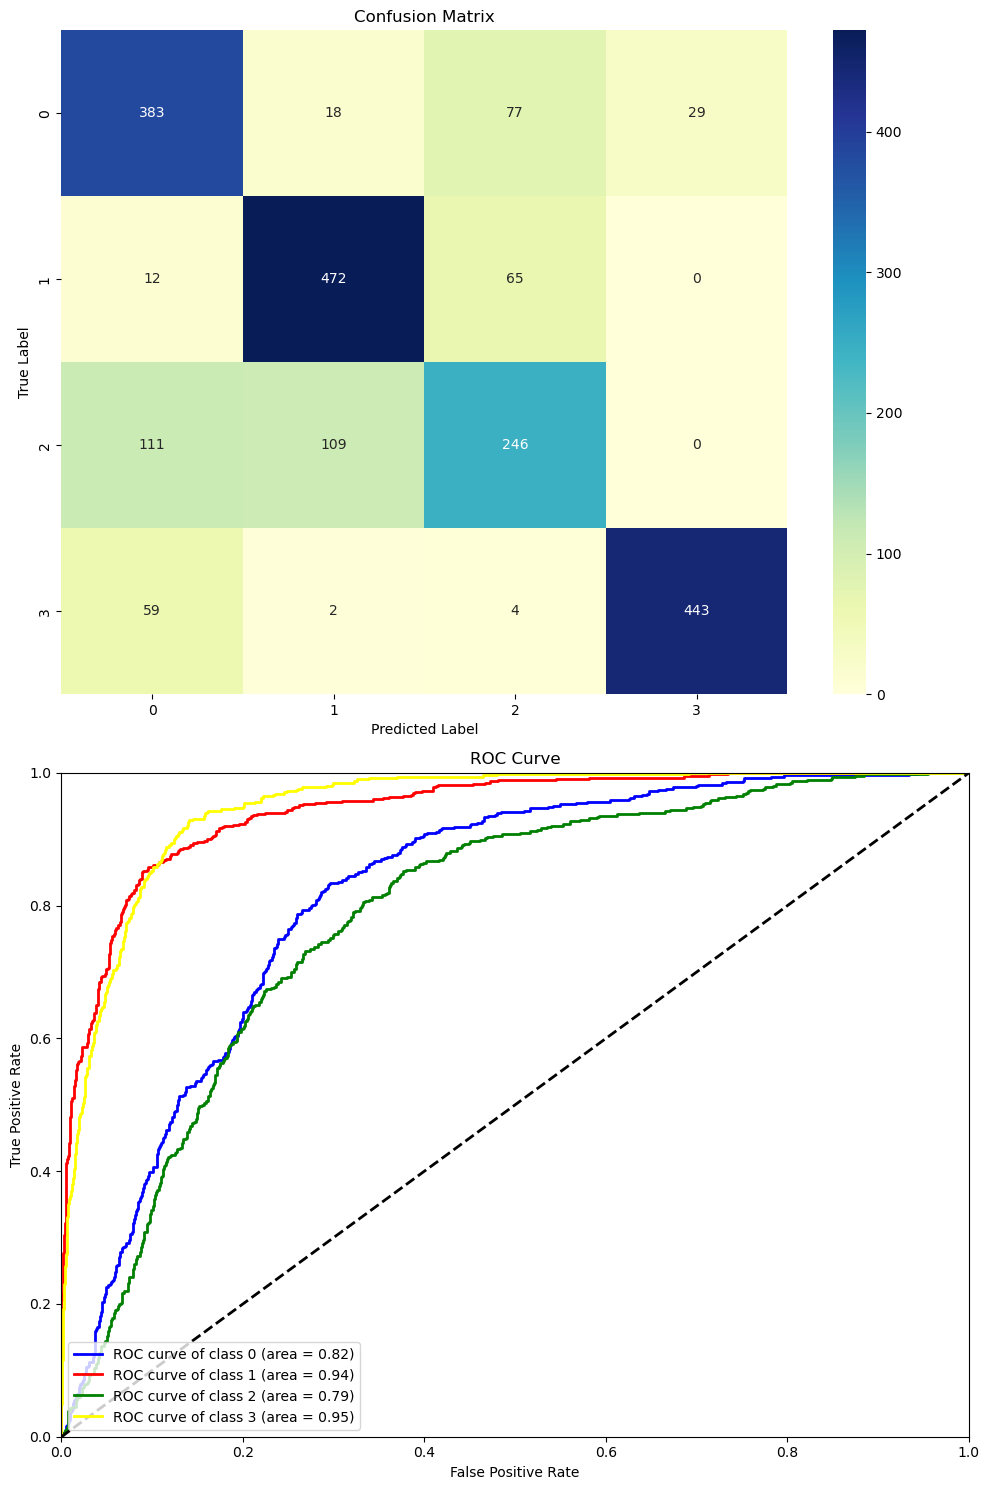

In [7]:
# Support Vector Machine
model_svm = Classifier(params_svm=params_svm)

## Fit the model
y_pred_svm, y_prob = model_svm.fit(X_train, y_train, X_test,'svm')

## Fine tune the model and get the best parameters
best_parameters, y_pred_opt = model_svm.tune(X_train, y_train, X_test, params_svm_grid, 'svm')
print(f"Best Parameters: {best_parameters}")

## Get the report for each metric
auc_score, svm_accuracy, report, confusion, percision, recall, f1, support = model_svm.report(y_pred_opt, y_test, y_prob)

print("\n Support Vector Machine")
print(f"AUC: {auc_score}")
print(f"Accuracy: {svm_accuracy}")
print(f"Report: {report}")
print(f"Confusion Matrix: {confusion}")
print(f"Percision: {percision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Support: {support}")

## Plot the confusion matrix and ROC curve
model_svm.plot(confusion, y_prob, y_test)

/Users/zeyuhan/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/zeyuhan/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/zeyuhan/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/zeyuhan/opt/anaconda3/envs/dsan5400/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/zeyuhan/opt/anaconda3/envs/dsan5400/lib/python3.11/si

Best Parameters: {'C': 0.1, 'max_iter': 3000, 'penalty': 'none', 'solver': 'saga'}

Logistic Regression
AUC: 0.8725918856216328
Accuracy: 0.6482758620689655
Report:               precision    recall  f1-score   support

           0       0.55      0.53      0.54       507
           1       0.71      0.88      0.78       549
           2       0.48      0.35      0.41       466
           3       0.78      0.78      0.78       508

    accuracy                           0.65      2030
   macro avg       0.63      0.64      0.63      2030
weighted avg       0.63      0.65      0.64      2030

Confusion Matrix: [[270  25 129  83]
 [ 20 484  45   0]
 [ 98 177 165  26]
 [104   0   7 397]]
Percision: 0.6336785313671326
Recall: 0.6482758620689655
F1: 0.6362219900115724
Support: [507 549 466 508]


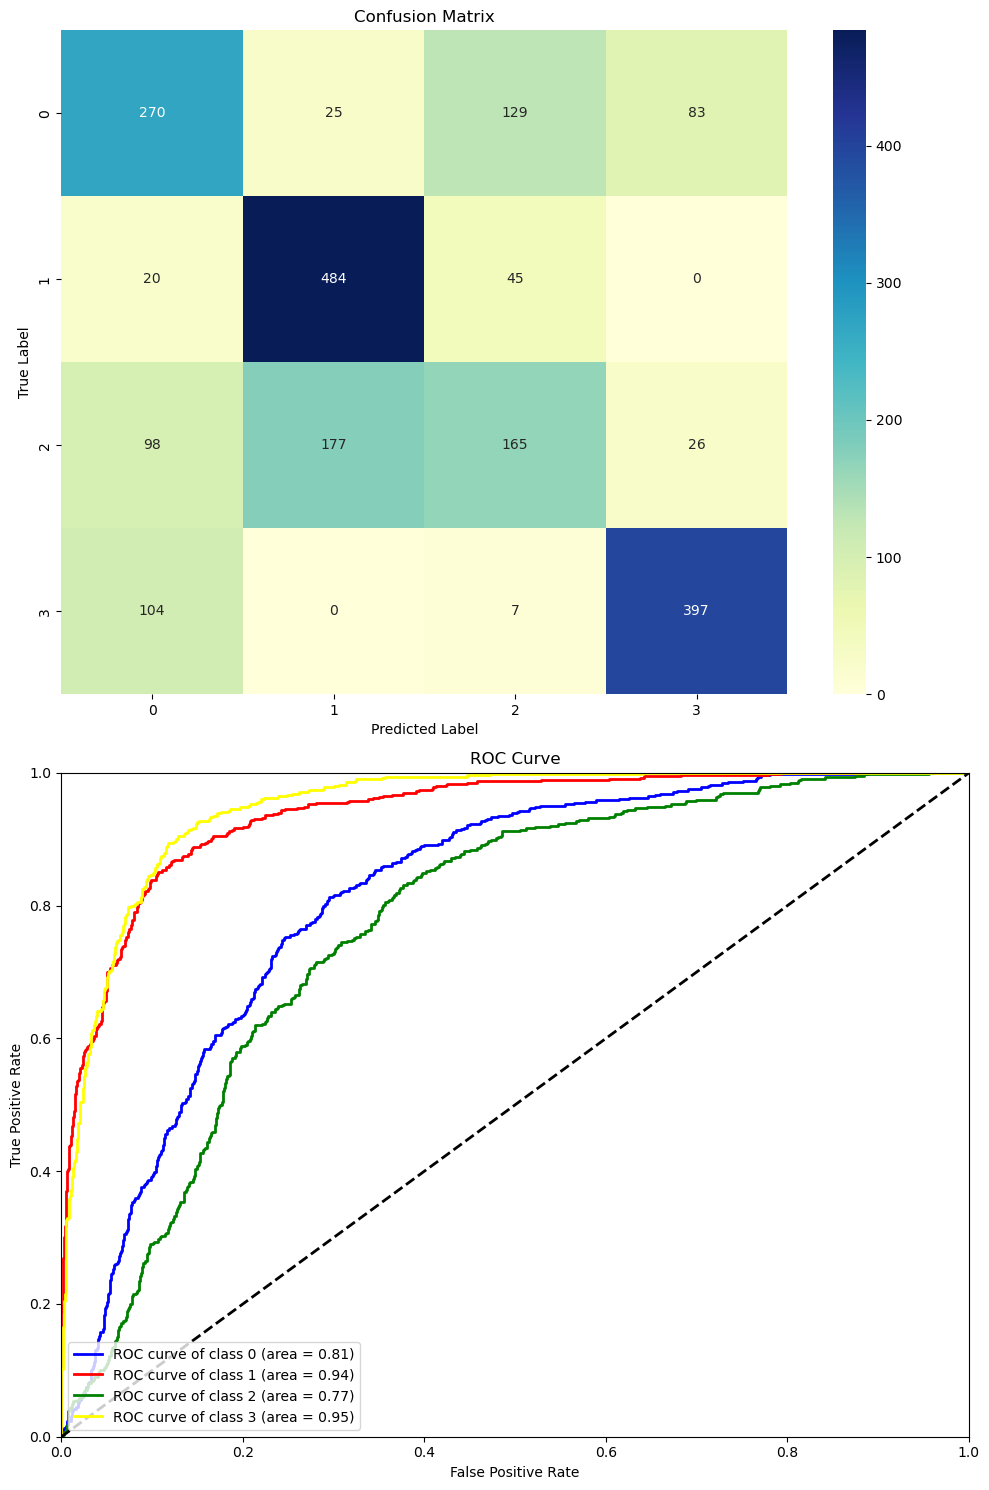

In [8]:
model_lrg = Classifier(params_lr=params_lr)

## Fit the model
y_pred_lrg, y_prob = model_lrg.fit(X_train, y_train, X_test,'lr')

## Fine tune the model and get the best parameters
best_parameters, y_pred_opt = model_lrg.tune(X_train, y_train, X_test, params_lr_grid, 'lr')
print(f"Best Parameters: {best_parameters}")

## Get the report for each metric
auc_score,lrg_accuracy, report, confusion, percision, recall, f1, support = model_lrg.report(y_pred_opt, y_test, y_prob)

print("\nLogistic Regression")
print(f"AUC: {auc_score}")
print(f"Accuracy: {lrg_accuracy}")
print(f"Report: {report}")
print(f"Confusion Matrix: {confusion}")
print(f"Percision: {percision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Support: {support}")

## Plot the confusion matrix and ROC curve
model_lrg.plot(confusion, y_prob, y_test)

In [60]:
table = pd.DataFrame({'Model': ['LR', 'SVM', 'LDA', 'QDA', 'RFC', 'Tree'],
                      'Accuracy': [lrg_accuracy, svm_accuracy, lda_accuracy, qda_accuracy, rfc_accuracy, tree_accuracy]})


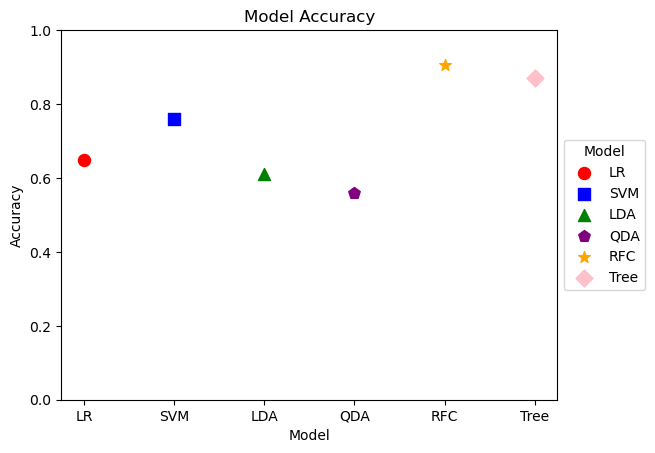

In [62]:
color_dict = {'LR': 'red', 'SVM': 'blue', 'LDA': 'green', 'QDA': 'purple', 'RFC': 'orange', 'Tree': 'pink'}
marker_dict = {'LR': 'o', 'SVM': 's', 'LDA': '^', 'QDA': 'p', 'RFC': '*', 'Tree': 'D'}

# Get current axis and its legend labels to manage legend entries
ax = plt.gca()
legend_labels = set()

# Create a scatter plot with different markers and colors
for i, row in table.iterrows():
    if row['Model'] not in legend_labels:
        plt.scatter(row['Model'], row['Accuracy'], color=color_dict[row['Model']],
                    marker=marker_dict[row['Model']], label=row['Model'], s = 75)
        legend_labels.add(row['Model'])
    else:
        plt.scatter(row['Model'], row['Accuracy'], color=color_dict[row['Model']],
                    marker=marker_dict[row['Model']], s = 75)

# Adding labels and title
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.1, 0.2))

# Adding legend to show marker and color associations
plt.legend(title="Model", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
